In [1]:
import os
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
from skimage import filters
# import cv2
from matplotlib import pyplot as plt
from skimage import io, filters, draw
import pandas as pd
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
from skimage.morphology import (closing, square, remove_small_objects, binary_erosion,
                                disk, binary_dilation, reconstruction)
from skimage.measure import regionprops, label
from skimage.segmentation import clear_border
from scipy.ndimage import binary_fill_holes
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from scipy import ndimage as ndi
from shutil import copy2
import six
from time import time
from skimage.filters import threshold_otsu, threshold_li
import re 
import sys
from PyQt5 import QtCore, QtWidgets
from PyQt5.QtWidgets import QApplication, QWidget, QFileDialog
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn, optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# %matplotlib

## Working FRAP Analysis

In [5]:
def show_gray_image (img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [6]:
def frap_region_measurements(labeled_img, img, counter):
    df = pd.DataFrame()
    properties = regionprops(labeled_img, intensity_image= img)
    for prop in properties:
        df = df.append([{'mean_intensity': prop.mean_intensity,
                                        'cell_label': prop.label,
                                         'cell_area': prop.area,
                                         'cell_bbox': prop.bbox,
                                         'cell_centroid': prop.centroid,
                                             'time_point': counter,
                                             },])
#     df = df.reset_index() 
    return df
    

In [7]:
def rand_region_measurements(img, rand_regions, region_list, counter):
    roi_df = pd.DataFrame()

    for val in region_list :
        if val >0:
            mean_val = np.mean(img[np.where(rand_regions==val)])
            roi_df = roi_df.append([{'mean_intensity': mean_val,
                                            'roi_label': val,
                                                 'time_point': counter,
                                                 },])
    return roi_df


In [8]:
def rect_region_measurements(img, bbox, counter):
    rect_df = pd.DataFrame()
    x1, y1, x2, y2 = bbox

    
    mean_val = np.mean(img[x1:x2, y1:y2])
    rect_df = rect_df.append([{'mean_intensity': mean_val,
                                         'time_point': counter,
                                         },])
    return rect_df


In [9]:
def obtain_seg_fields_cell_and_frap_area(rpath, cell_sigma =3, cell_min_area = 1000, 
                                         sigma = 5, smallest_region = 50, 
                                         rec_width = 20, dial_rad = 33):
    '''
    Inputs:
    rpath : root path of the images
    cell_sigma: sigma to be used in the Gaussian blurring of the images for cell segmentation
    cell_min_area: minimum number of pixels to be considered a cell region
    sigma : sigma to be used in the Gaussian blurring of the images for frap region segmentation
    smallest_region : minimum number of pixels to be considered a frapped region of interest
    rec_width : width of the rectange being drawn for regions to be used for bleach correction
    dial_rad : radius of the disk to be drawn with the centroid as the center 
                of the disk for getting the approximate frapped region
    
    Outputs:
    dif: differnce of the last pre-bleach and first post-bleach images after they have been blurred
    seg: segmented image without any post-processing
    labeled_img: labeled image after the post-processing
    df: data frame containing the details of the measurements for all the images and all the objects in them
    '''
    # get all the tif images in the directory/subdirectories of rpath
    x = [os.path.join(r,file) for r,d,f in os.walk(rpath) for file in f if file.endswith('.tif')]
    
    # list of all pre-bleach images
    pre_img_names = [fname for fname in x if 'pre' in os.path.basename(fname).lower()]
    
    # read the last time point in the pre-bleached image names
    O = io.imread( pre_img_names[-1])
    # Gaussian blur last pre-bleach and segment the cell areas
    blur = filters.gaussian(O, cell_sigma)
    cell_seg = blur > threshold_otsu(blur)
    
    # remove the objects that are not cell like based on area threshold
    cell_seg = remove_small_objects(cell_seg, cell_min_area)
    # label the cells
    cell_labels = label(cell_seg)
    
    # list of all post-bleach images
    pb_img_names = [fname for fname in x if 'pb' in os.path.basename(fname).lower()]
    
    # Gaussian blur last pre-bleach and first post-bleach images; subtract these blurred images
    dif = filters.gaussian(O, sigma)- filters.gaussian(io.imread(pb_img_names[0]), sigma)
    
    # Use otsu segmentation method to automatically obtain a threshold
    seg = dif > threshold_otsu(dif)
    
    
    # fill any hole in the segmented objects
    no_hole = ndi.binary_fill_holes(seg)
    
    # remove small objects defined by a threshold on area (in pixels)
    no_hole = remove_small_objects(no_hole, smallest_region)
    
    # clear border
    no_hole = clear_border(no_hole)
    
    # label the detected objects in the subtracted image
    labeled_img = label(no_hole)
    properties = regionprops(labeled_img, intensity_image = dif)
  # create a placeholder image
    roi_img = np.zeros_like(labeled_img)

    # get the maximum value in the frapped regions on to the placeholder image
    for prop in properties:
         # create a placeholder image
#         roi_img = np.zeros_like(labeled_img)
        temp_image = labeled_img == prop.label
        dif_temp = dif*temp_image
        x0, y0 = np.int(np.mean(np.where(dif == prop.max_intensity)[0])), np.int(np.mean(np.where(dif == prop.max_intensity)[1]))
        roi_img[x0, y0] = 1
         # dialate each frapped region with a disk of radius (dial_rad) and label the resulting image
        rr, cc = draw.circle(x0, y0, dial_rad)
        roi_img[rr, cc] = 1
# #         roi_img = binary_dilation(roi_img, disk(dial_rad))
#         temp_img = roi_img*blur
#         thresh = threshold_otsu(blur[np.where(temp_img>0)])
#         region = temp_img>thresh
#         rois = rois + region
        

    labeled_img = label(roi_img)
    print('Number of FRAPed regions ', np.max(labeled_img))
    
#     labeled_img = label(no_hole)
    # cell labels whith frap regions
    intersection = np.logical_and(labeled_img, cell_labels)
    to_rem = cell_labels*intersection
    
    tmp = np.zeros_like(cell_labels)
    regions = regionprops(cell_labels)
    for region in regions:
        if region.label not in list(np.unique(to_rem)):
            x,y = int(region.centroid[0]), int(region.centroid[1])
            lx, ux = max(x-rec_width, 0), min(x+rec_width, tmp.shape[0])
            ly, uy = max(y-rec_width, 0), min(y+rec_width, tmp.shape[1])
            tmp[lx:ux, ly:uy] = 1
    rand_regions = tmp*cell_labels
    region_list = list(np.unique(rand_regions))
#     plt.imshow(rand_regions)
    
    # generate an empty lists for frap region measurements and selected non-frap region measurements
    frap_dfs =[]
    roi_dfs =[]
    # combine pre and post bleach images in the right order
    all_img_names = pre_img_names.copy()
    all_img_names.extend(pb_img_names)
    
    # intialize a counter
    counter = 0
    # calculate the region properties from each image in the frap regions and selected non-frap regions
    for num, fname in enumerate(all_img_names):
        img = io.imread(fname)
        counter= counter + 1
        frap_dfs.append(frap_region_measurements(labeled_img, img, counter))
        roi_dfs.append(rand_region_measurements(img, rand_regions, region_list, counter))
        

    # concatenate and reset index for frap regions dataframe  
    df = pd.concat(frap_dfs)
    df = df.reset_index()
#     print(df)
    # concatenate and reset index for non-frap regions dataframe 
    rand_roi_df = pd.concat(roi_dfs)
    rand_roi_df = rand_roi_df.reset_index()


    return dif, cell_seg, seg, labeled_img, rand_regions, df, rand_roi_df

In [10]:
def obtain_normalized_mean_intensities(ndf, col_name, normalize = True):
    normalized_int = np.zeros((len(ndf[col_name].unique()), len(ndf['time_point'].unique())))
    
    for ii, lab in enumerate(ndf[col_name].unique()):

        avg_intensity = list(ndf[ndf[col_name]==lab].mean_intensity)
        if normalize:
            normalized_avg_intensity = [avg_int/avg_intensity[0] for avg_int in avg_intensity]
            normalized_int[ii,:] = normalized_avg_intensity
        else:
            normalized_avg_intensity = avg_intensity
            normalized_int[ii,:] = normalized_avg_intensity
            
        
    
    return normalized_int


In [11]:
def obtain_bleach_corr_coef(x,a):
#     result = np.exp(a*t)
    return np.exp(a*x)

In [12]:
def fit_recovery(x, b, d, c):
    return b * np.exp(-d * x) + c

In [13]:
def get_cmap(n, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


## User selects the directory containing images

A window will pop up. Select the top level of the direcotory containing both pre-and post bleach images.

In [14]:
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
rpath = QFileDialog.getExistingDirectory(caption = 'Select FRAP root path')
print("Root directory: ", rpath)

Root directory:  E:/MBolt/FRAP/190911_Sheena_FRAP/4HT_2


In [15]:
dif, cell_seg, seg, labeled_img, rand_regions, df, rand_roi_df = obtain_seg_fields_cell_and_frap_area(rpath, 
                                                                                                      cell_sigma =3, 
                                                                                                      cell_min_area = 1000, 
                                                                                                      sigma = 10,
                                                                                                      smallest_region = 200,
                                                                                                      rec_width = 20, 
                                                                                                      dial_rad = 15)


Number of FRAPed regions  5


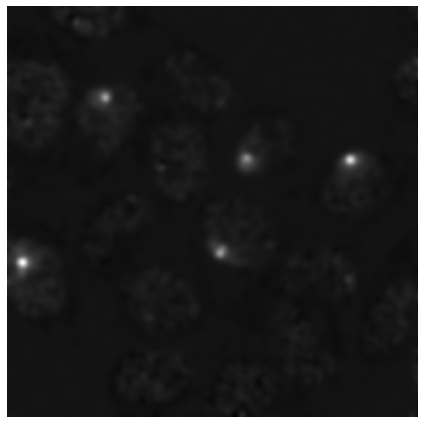

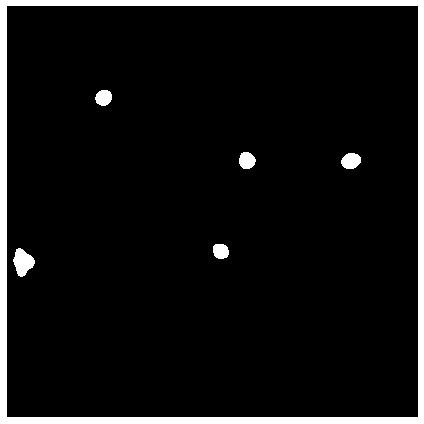

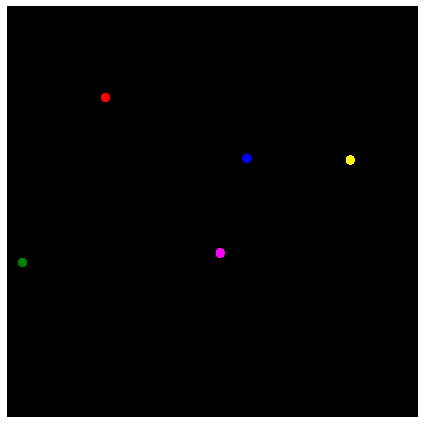

In [16]:
# diff image
show_gray_image(dif)
# segmented image (Frapped regions)
show_gray_image(seg)
# labeled frapped regions
show_gray_image(label2rgb(labeled_img, bg_label=0))

In [105]:
# show_gray_image(mark_boundaries(dif*10, rand_regions, color = (1,0,0), outline_color = (0,1,0)))

In [106]:
# show_gray_image(mark_boundaries(dif*10, labeled_img, color = (1,0,0), outline_color = (0,1,0)))

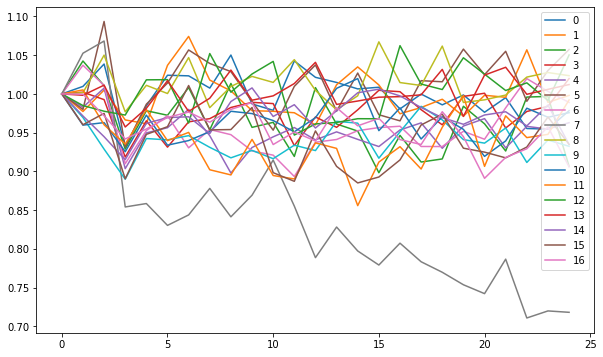

In [17]:
normalized_int  = obtain_normalized_mean_intensities(rand_roi_df, 'roi_label', normalize = True)
show_curves = True # change this to True if you wish to see the curves
if show_curves:
    # normalized_int  = obtain_normalized_mean_intensities(df, 'cell_label', normalize = False)
    fig, ax = plt.subplots(figsize=(10, 6))
    for lab in range(normalized_int.shape[0]):
        ax.plot(normalized_int[lab,:],  label =lab)
    # plt.ylim((0.85,1.20))
    plt.legend()
    plt.show()


In [18]:
tif_files = [os.path.join(r,file) for r,d,f in os.walk(rpath) for file in f if file.endswith('.tif')]
    
# list of all pre-bleach images
pre_img_names = [fname for fname in tif_files if 'pre' in fname.lower()]

# first two images/times in the post bleach are not also eliminated for the bleach correction
starting_point = len(pre_img_names) + 2 
# bleach time point (first) index
st_pt = len(pre_img_names)

# user defined values
time_btw_two_imges = 1.16
stoppage_time = 1.5
print('starting point for bleach correction', starting_point)
print('starting point for recovery curve fit', st_pt)

# Bleach correction setp
# starting_point = 5
med = np.median(normalized_int, axis=0)
x = np.linspace(1,len(med), len(med))
fit_x = x[starting_point:]
fit_med = med[starting_point:]
p1, _= optimize.curve_fit(obtain_bleach_corr_coef, xdata=x-(starting_point+1), ydata=med, method='lm')
bleach_corr_fact = np.exp(-np.linspace(0,len(med)-1, len(med))*p1[0])

starting point for bleach correction 5
starting point for recovery curve fit 3


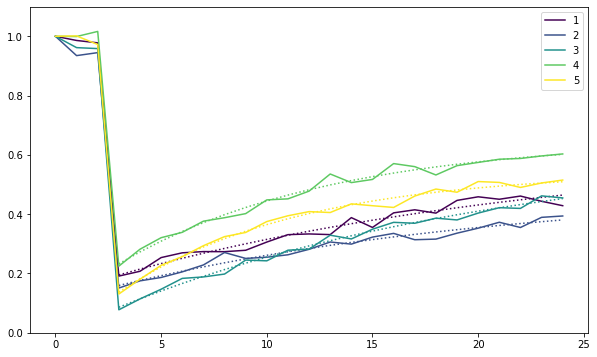

t_half is :  4.76134620700184
immobile fraction is :  0.5182203491433759
writing to:  E:/MBolt/FRAP/190911_Sheena_FRAP/4HT_2\4HT_2.csv


In [32]:
col_name = 'cell_label'
x_fit = x[st_pt:]
fig, ax = plt.subplots(figsize=(10, 6))
cmap = get_cmap(len(df[col_name].unique()))

df_res = pd.DataFrame()
overall_data = pd.DataFrame()

filename = os.path.basename(rpath)
split_names = filename.split('_')
treatment, field = '_'.join(split_names[:-1]), split_names[-1]

for ii, lab in enumerate(df[col_name].unique()):
    frap_region_centroid = list(df[df[col_name]==lab].cell_centroid)[0]
    frap_region_bbox = list(df[df[col_name]==lab].cell_bbox)[0]
    
    avg_intensity = list(df[df[col_name]==lab].mean_intensity)
    normalized_avg_intensity = [avg_int/avg_intensity[0] for avg_int in avg_intensity]
    corrected_intensity = normalized_avg_intensity
    ax.plot(corrected_intensity,  label =lab, c=cmap(ii))
    
    cor_dic = {'filename': filename,
                              'field': field,
                             'treatment': treatment,
              'frap_region_bbox': frap_region_bbox}
    for i in range(len(corrected_intensity)):
        cor_dic['time_' + str(i).zfill(2)] = corrected_intensity[i]
     
                                    
    overall_data = overall_data.append([cor_dic, ])
    
    frap_fit = corrected_intensity[st_pt:]
    p, _= optimize.curve_fit(fit_recovery, xdata=x_fit-(st_pt+1), ydata=frap_fit, method='lm', maxfev =10000)
    fitted_values = fit_recovery(x_fit-(st_pt+1), *p)
    a = 0.5*fitted_values[-1]
    b,d,c = p
    ax.plot(x_fit-1, fitted_values, ':', c=cmap(ii))
    t_half = np.log((a-c)/b)/(-d)
    half_life = t_half*time_btw_two_imges + stoppage_time # t-half in seconds
    
    imb_fraction = 1-fitted_values[-1]
    
    df_res = df_res.append([{'filename': filename,
                              'field': field,
                             'treatment': treatment,
                                'half_life': half_life,
                                'frap_region_num': lab,
                                'immobile_fraction': imb_fraction,
                                'frap_region_centroid': frap_region_centroid,
                                 'frap_region_bbox': frap_region_bbox,
                                             },])

df_res = df_res.reset_index()
overall_data = overall_data.reset_index()
plt.ylim((0,1.1))
plt.legend()
plt.show()    

print('t_half is : ', df_res['half_life'].mean())
print('immobile fraction is : ', df_res['immobile_fraction'].mean() )
df_res.to_csv(os.path.join(rpath, filename + '.csv'), index=False)
overall_data.to_csv(os.path.join(rpath, filename + '_runs.csv'), index=False)
print('writing to: ' ,os.path.join(rpath, filename + '.csv'))

# Combine all the csv files 

#### Once all the regions/images are analyzed, run the following:

In [110]:
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
root_path = QFileDialog.getExistingDirectory(caption = 'Select FRAP root path')
print("Root directory: ", root_path)

Root directory:  F:/Bolt_Images/Leica_Images/210722_Priscilla_siRNA_FRAP


In [111]:
csv_files = [os.path.join(r,file) for r,d,f in os.walk(root_path) for file in f if file.endswith('.csv') and not 'runs' in file]
comb_df = []
for file in csv_files:
    comb_df.append(pd.read_csv(os.path.join(root_path, file)))
combined_csv = pd.concat(comb_df)
combined_csv.to_excel(os.path.join(root_path, 'combined_frap_measurements.xlsx'), index = False)

In [112]:
csv_files = [os.path.join(r,file) for r,d,f in os.walk(root_path) for file in f if file.endswith('runs.csv')]
comb_df = []
for file in csv_files:
    comb_df.append(pd.read_csv(os.path.join(root_path, file)))
combined_csv = pd.concat(comb_df)
combined_csv.to_excel(os.path.join(root_path, 'combined_frap_measurements_runs.xlsx'), index = False)

# Scratch Space

In [24]:
# roi_img = np.zeros_like(labeled_img)
# for prop in properties:
#     temp_image = labeled_img == prop.label
#     dif_temp = dif*temp_image
#     x0, y0 = np.int(np.mean(np.where(dif == prop.max_intensity)[0])), np.int(np.mean(np.where(dif == prop.max_intensity)[1]))
#     roi_img[x0, y0] = 1
# dialted_img = binary_dilation(roi_img, disk(15))
# show_gray_image(dialted_img)
# #     show_gray_image(prop.image)

In [20]:
# x = [os.path.join(r,file) for r,d,f in os.walk(rpath) for file in f if file.endswith('.tif')]

In [21]:
# pre_img_names = [fname for fname in x if 'pre' in os.path.basename(fname).lower()]
# len(pre_img_names)

In [22]:
# len([fname for fname in x if 'pb' in os.path.basename(fname).lower()])

In [23]:
# len([fname for fname in x if 'pb' in fname.lower()])